Курсовой проект для курса "Python для Data Science"

Материалы к проекту (файлы):
train.csv
test.csv

Задание:
Используя данные из обучающего датасета (train.csv), построить модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели, предсказать цены для квартир из тестового датасета (test.csv).

Целевая переменная:
Price

Метрика качества:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Требования к решению:
1. R2 > 0.6
2. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}_solution.ipynb, пример SShirkin_solution.ipynb
3. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}_predictions.csv, пример SShirkin_predictions.csv 
Файл должен содержать два поля: Id, Price и в файле должна быть 5001 строка (шапка + 5000 предсказаний).

Сроки сдачи:
Cдать проект нужно в течение 72 часов после окончания последнего вебинара. Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества. Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

In [4]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.metrics import r2_score as r2, accuracy_score
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
matplotlib.rcParams.update({'font.size': 14})

In [7]:
def evaluare_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print('Train R2:\t' + str(round(r2(train_true_values, train_pred_values), 3)))
    print('Test R2:\t' + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18, 10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')
    
    plt.show()

In [8]:
def show_dst(train_df, column):
    plt.figure(figsize=(16,8))
    
    train_df[column].hist(bins=8)
    plt.ylabel('Count')
    plt.xlabel(column)
    
    plt.title('Target distribution')
    plt.show()
    return None

#### Пути к директориям и файлам

In [189]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

### Загрузка данных

#### Описание датасета:

* Id - идентификационный номер квартиры
* DistrictId - идентификационный номер района
* Rooms - количество комнат
* Square - площадь
* LifeSquare - жилая площадь
* KitchenSquare - площадь кухни
* Floor - этаж
* HouseFloor - количество этажей в доме
* HouseYear - год постройки дома
* Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
* Social_1, Social_2, Social_3 - социальные показатели местности
* Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
* Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
* Price - цена квартиры

In [317]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
print(train_df.shape)
train_df.head()

(10000, 20)


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [318]:
train_df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [319]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [320]:
train_df.nunique()

Id               10000
DistrictId         205
Rooms                9
Square           10000
LifeSquare        7887
KitchenSquare       58
Floor               33
HouseFloor          44
HouseYear           97
Ecology_1          129
Ecology_2            2
Ecology_3            2
Social_1            51
Social_2           142
Social_3            30
Healthcare_1        79
Helthcare_2          7
Shops_1             16
Shops_2              2
Price            10000
dtype: int64

In [322]:
features_to_drop = ['Id']
features_to_drop = features_to_drop + ['Healthcare_1', 'LifeSquare']

### Базовая модель, выбрасываем признаки

In [323]:
train_df.replace({'Ecology_2': {'A':0, 'B':1}, 'Ecology_3': {'A':0, 'B':1}, 'Shops_2': {'A':0, 'B':1}}, inplace=True)

In [324]:
# заменяем DistrictId на Среднюю/медианную цену дома в конкретном районе
median_price_by_did = train_df.groupby('DistrictId')[['Price']].median().reset_index()

In [325]:
train_df = pd.merge(train_df, median_price_by_did, how='left', on='DistrictId')
train_df = train_df.drop(['DistrictId'], axis='columns').rename(columns={'Price_x': 'Price', 'Price_y': 'median_price_by_did'})

#### Обработка пропусков

In [326]:
train_df.isna().sum()

Id                        0
Rooms                     0
Square                    0
LifeSquare             2113
KitchenSquare             0
Floor                     0
HouseFloor                0
HouseYear                 0
Ecology_1                 0
Ecology_2                 0
Ecology_3                 0
Social_1                  0
Social_2                  0
Social_3                  0
Healthcare_1           4798
Helthcare_2               0
Shops_1                   0
Shops_2                   0
Price                     0
median_price_by_did       0
dtype: int64

In [327]:
# заполняем LifeSquare как (Square - KitchenSquare) * 0.65
def fill_LifeSquare(data):
    data.loc[(data['Square'] < data['LifeSquare']) | (data['LifeSquare'].isna()), 'LifeSquare'] = \
    (data.loc[(data['Square'] < data['LifeSquare']) | (data['LifeSquare'].isna()), 'Square'] - \
    data.loc[(data['Square'] < data['LifeSquare']) | (data['LifeSquare'].isna()), 'KitchenSquare']) * 0.65
    return data

In [328]:
train_df = fill_LifeSquare(train_df)
train_df.isna().sum()

Id                        0
Rooms                     0
Square                    0
LifeSquare                0
KitchenSquare             0
Floor                     0
HouseFloor                0
HouseYear                 0
Ecology_1                 0
Ecology_2                 0
Ecology_3                 0
Social_1                  0
Social_2                  0
Social_3                  0
Healthcare_1           4798
Helthcare_2               0
Shops_1                   0
Shops_2                   0
Price                     0
median_price_by_did       0
dtype: int64

In [329]:
# Самые часто встречающиеся значения по признакам
train_df.apply(lambda x: dict(x.value_counts().head(1)))

Id                                  {11549.0: 1}
Rooms                                {2.0: 3880}
Square                    {81.05304359102703: 1}
LifeSquare               {35.812831832030454: 1}
KitchenSquare                        {1.0: 2460}
Floor                                 {4.0: 949}
HouseFloor                          {17.0: 2331}
HouseYear                         {1977.0: 2652}
Ecology_1                     {0.007122317: 587}
Ecology_2                            {1.0: 9903}
Ecology_3                            {1.0: 9725}
Social_1                              {2.0: 688}
Social_2                            {264.0: 587}
Social_3                             {0.0: 2997}
Healthcare_1                        {540.0: 511}
Helthcare_2                          {0.0: 4214}
Shops_1                              {0.0: 2316}
Shops_2                              {1.0: 9175}
Price                      {207103.209096882: 1}
median_price_by_did    {146171.43318971686: 851}
dtype: object

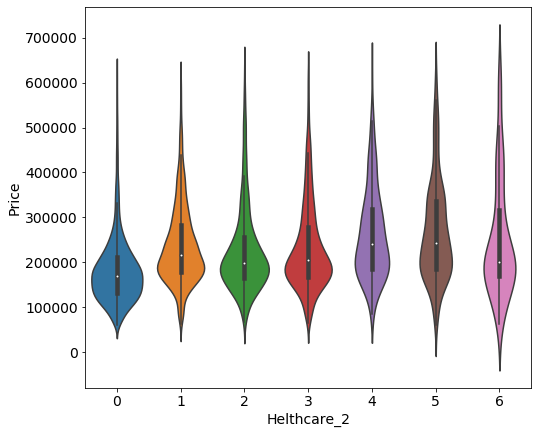

In [330]:
sns.violinplot(train_df.Helthcare_2, train_df.Price)

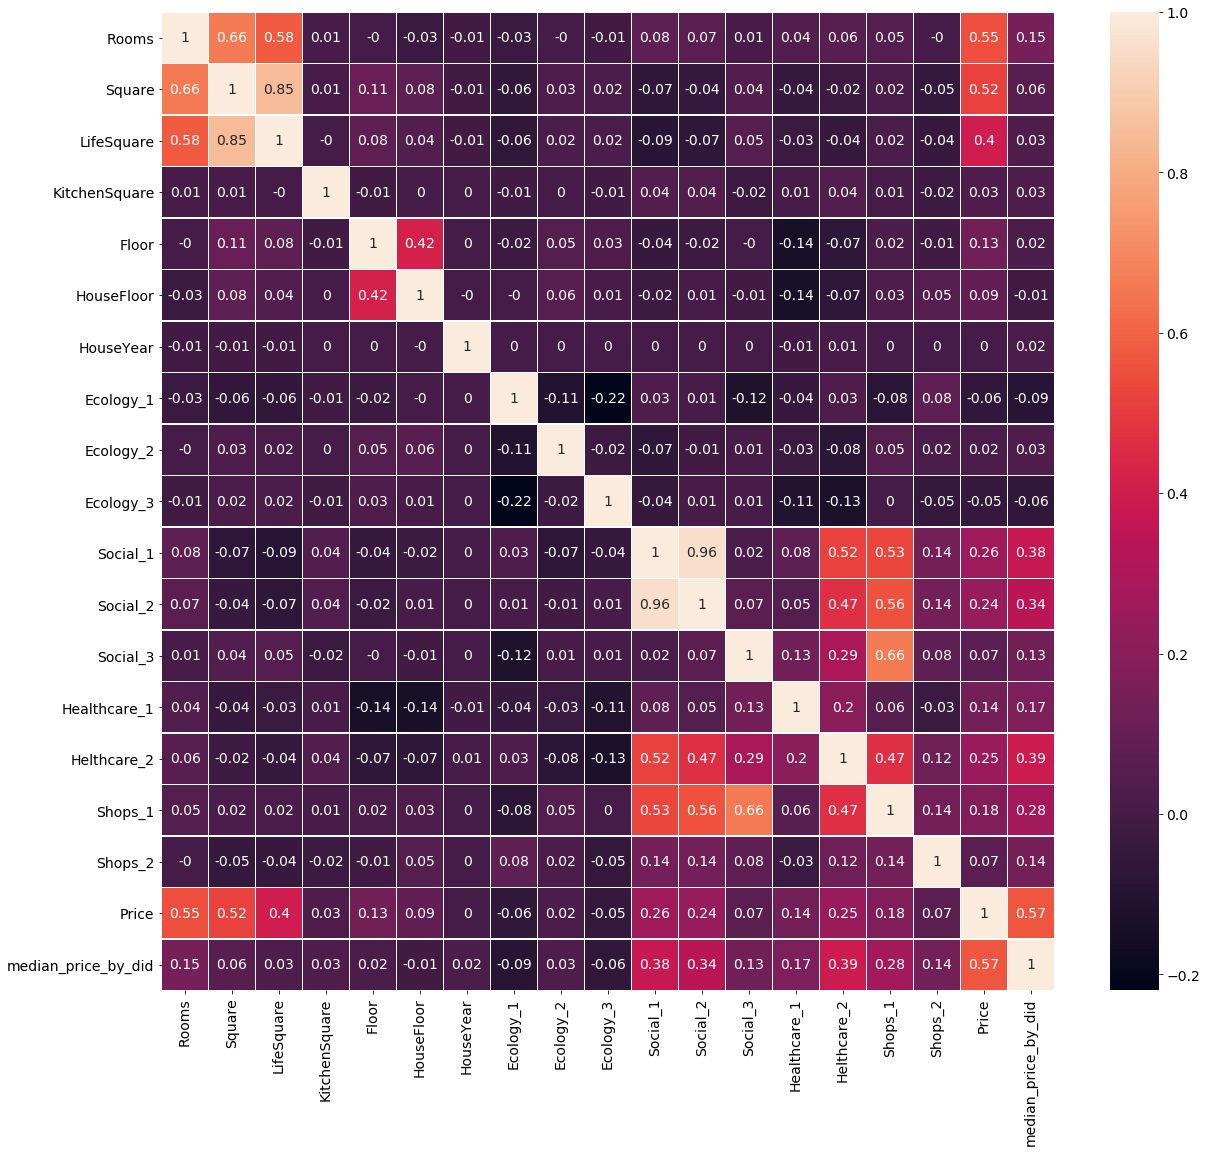

In [331]:
# матрица корреляций
from matplotlib import rcParams
rcParams['figure.figsize'] = 20, 18
sns.heatmap(train_df.drop(['Id'], axis='columns').corr().round(2), annot=True, linewidth=.5)

In [332]:
# Заполнение пропусков Healthcare_1
def ident_model(data):
    model = RandomForestClassifier(max_depth=15)
    train = data[data['Healthcare_1'].isna() == False][['median_price_by_did', 'Social_1', 'Social_2', 'Social_3', 'Helthcare_2', 'Healthcare_1']]
    tr, tst = train_test_split(train, test_size=0.15, random_state=67)
    model.fit(tr.drop('Healthcare_1', axis='columns'), tr['Healthcare_1'])
    pred = model.predict(tst.drop('Healthcare_1', axis='columns'))
    print(accuracy_score(tst['Healthcare_1'], pred))
    
    test = data[data['Healthcare_1'].isna()][['median_price_by_did', 'Social_1', 'Social_2', 'Social_3', 'Helthcare_2', 'Healthcare_1']]
    model.fit(train.drop('Healthcare_1', axis='columns'), train['Healthcare_1'])
    pred = model.predict(test.drop('Healthcare_1', axis='columns'))  

    return model


def fill_H1(model, data):
    test = data[data['Healthcare_1'].isna()][['median_price_by_did', 'Social_1', 'Social_2', 'Social_3', 'Helthcare_2', 'Healthcare_1']]
    pred = model.predict(test.drop('Healthcare_1', axis='columns'))
    return pred

In [333]:
train_df.loc[train_df['Healthcare_1'].isna(), 'Healthcare_1'] = fill_H1(ident_model(train_df), train_df)

0.998719590268886


In [357]:
# подбираем гиперпризнаки моедли
rcParams['figure.figsize'] = 8, 7

def test_model_params(data, features_to_drop):
    X_train, X_test, y_train, y_test = train_test_split(data.drop(features_to_drop + ['Price'], axis = 1), data['Price'], test_size=0.20, random_state=22)
    r2_train = []
    r2_test = []
    max_depth = list(range(11, 19))
    for i in max_depth:
        model = RandomForestRegressor(max_depth=i, n_estimators=220)
        model.fit(X_train, y_train)
        pr_train = model.predict(X_train)
        pr_test = model.predict(X_test)
        r2_train.append(r2(y_train, pr_train))
        r2_test.append(r2(y_test, pr_test))

    imp = pd.DataFrame()
    imp['name'] = X_train.columns
    imp['value'] = model.feature_importances_
    print(imp.sort_values('value', ascending = False))
    print(r2_test)
    plt.scatter(max_depth, r2_train, c='r')
    plt.scatter(max_depth, r2_test, c='b')
    plt.grid(True)

                   name     value
1                Square  0.421144
15  median_price_by_did  0.309806
0                 Rooms  0.038068
5             HouseYear  0.036648
11             Social_3  0.029151
3                 Floor  0.028669
2         KitchenSquare  0.025258
9              Social_1  0.025190
4            HouseFloor  0.022897
10             Social_2  0.022701
6             Ecology_1  0.018061
13              Shops_1  0.012442
12          Helthcare_2  0.007828
14              Shops_2  0.001137
8             Ecology_3  0.000892
7             Ecology_2  0.000108
[0.7200126366225014, 0.7226154638622593, 0.7277818621114047, 0.7239130397572205, 0.7253320970796531, 0.7221763351058621, 0.7211918441222558, 0.7203790218404984]


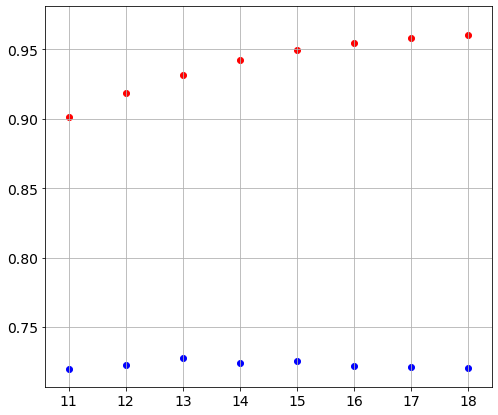

In [355]:
test_model_params(train_df, features_to_drop)

In [358]:
features_to_drop = features_to_drop + ['HouseFloor', 'Ecology_1', 'Shops_1', 'Helthcare_2', 'Shops_2', 'Ecology_3', 'Ecology_2']

                  name     value
1               Square  0.436148
8  median_price_by_did  0.316883
4            HouseYear  0.043749
7             Social_3  0.038346
0                Rooms  0.036967
3                Floor  0.033623
5             Social_1  0.032867
6             Social_2  0.030886
2        KitchenSquare  0.030533
[0.7309429334350966, 0.7319639238317193, 0.7323958406515845, 0.7328595145032095, 0.7319837967627191, 0.7338734164345218, 0.7345865782068057, 0.7300842594174659]


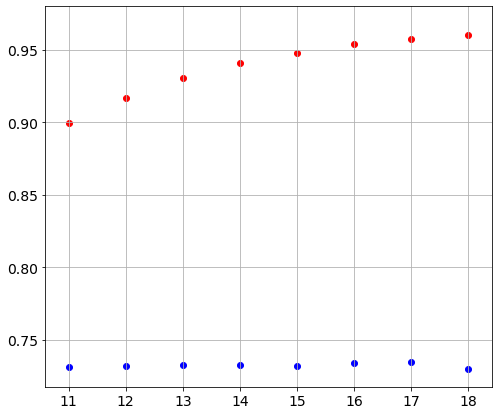

In [359]:
test_model_params(train_df, features_to_drop)

In [360]:
X_train, X_test, y_train, y_test = train_test_split(train_df.drop(features_to_drop + ['Price'], axis='columns'), 
    train_df['Price'], test_size=0.2, random_state=22)

In [361]:
# Модель, основанная на признаках, где нет пропущенных значений
model_RFR = RandomForestRegressor(max_depth=17, n_estimators=200, random_state=55)
model_RFR.fit(X_train, y_train)
first_predict = model_RFR.predict(X_test)
r2(y_test, first_predict)

0.7323681924649207

In [362]:
# переобучаем на всех данных
model_RFR = RandomForestRegressor(max_depth=15, n_estimators=200, random_state=55)
model_RFR.fit(train_df.drop(features_to_drop + ['Price'], axis='columns'), train_df['Price'])

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=15, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=55, verbose=0, warm_start=False)

In [363]:
features_to_drop

['Id',
 'Healthcare_1',
 'LifeSquare',
 'HouseFloor',
 'Ecology_1',
 'Shops_1',
 'Helthcare_2',
 'Shops_2',
 'Ecology_3',
 'Ecology_2']

In [364]:
# загружаем тестовые данные
test = pd.read_csv(TEST_DATASET_PATH)
# test.replace({'Ecology_2': {'A':0, 'B':1}, 'Ecology_3': {'A':0, 'B':1}, 'Shops_2': {'A':0, 'B':1}}, inplace=True)

In [365]:
test = pd.merge(test, median_price_by_did, how='left', on='DistrictId')

In [366]:
test = test.drop(['DistrictId'], axis='columns').rename(columns={'Price': 'median_price_by_did'})
test['median_price_by_did'] = test['median_price_by_did'].fillna(test['median_price_by_did'].median())

#test = fill_LifeSquare(test)
#test.loc[test['Healthcare_1'].isna(), 'Healthcare_1'] = fill_H1(ident_model(test), test)

# test.isnull().sum()

In [367]:
test.shape

(5000, 19)

In [368]:
X_test.shape

(2000, 9)

In [369]:
# первое предсказание с базовой модели на тестовых данных
test_first_predict = model_RFR.predict(test.drop(features_to_drop, axis='columns'))

In [370]:
test['Price'] = test_first_predict
test.head()

,Id,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,median_price_by_did,Price
0,725,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B,151557.904767,158918.681556
1,15856,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,195610.960042,222188.987776
2,5480,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B,526438.458919,401776.921096
3,15664,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B,196429.659238,339213.382964
4,14275,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A,146171.433190,144918.113889


In [371]:
test[['Id', 'Price']].to_csv('first_predict_27082020.csv', index = False)

In [372]:
f_importance = pd.DataFrame()
f_importance['name'] = test.drop(features_to_drop + ['Price'], axis='columns').columns.to_list()
f_importance['values'] = model_RFR.feature_importances_
f_importance.sort_values('values', ascending = False).reset_index(drop=True)

,name,values
0,Square,0.437668
1,median_price_by_did,0.319039
2,HouseYear,0.043366
3,Social_3,0.036152
4,Rooms,0.034985
5,Social_1,0.032961
6,Social_2,0.032665
7,Floor,0.031659
8,KitchenSquare,0.031506
